In [ ]:
%pip install pandas
%pip install scikit-learn
%pip install seaborn
%pip install matplotlib
%pip install xgboost
%pip install imblearn
%pip install numpy
%pip install shap

   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ------------------------------- -------- 2.1/2.7 MB 19.5 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 10.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/28.1 MB ? eta -:--:--
   ---- ----------------------------------- 3.4/28.1 MB 16.8 MB/s eta 0:00:02
   --------------- ------------------------ 11.0/28.1 MB 26.5 MB/s eta 0:00:01
   --------------------------- ------------ 19.1/28.1 MB 31.0 MB/s eta 0:00:01
   -------------------------------- ------- 23.1/28.1 MB 28.1 MB/s eta 0:00:01
   ---------------------------------------- 28.1/28.1 MB 29.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


<h3> IMPORTS </h3>

In [55]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import joblib
import shap

c:\Users\jorge\Proyectos Python\NotMaster\FootballResults\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h3>Preparación de Datos y Exploración</h3>

In [2]:
df = pd.read_csv('data/SP1.csv')

#First five rows of dataframe
df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,BFECAHH,BFECAHA
0,SP1,15/08/2024,18:00,Ath Bilbao,Getafe,1,1,D,1,0,...,2.08,1.73,2.17,1.76,2.19,1.82,2.12,1.77,2.19,1.82
1,SP1,15/08/2024,20:30,Betis,Girona,1,1,D,1,0,...,2.01,1.89,2.03,1.89,2.10,1.94,2.01,1.85,2.08,1.90
2,SP1,16/08/2024,18:00,Celta,Alaves,2,1,H,0,1,...,1.82,2.11,1.83,2.10,1.84,2.12,1.79,2.08,1.85,2.14
3,SP1,16/08/2024,20:30,Las Palmas,Sevilla,2,2,D,1,1,...,1.86,2.07,1.87,2.07,1.89,2.11,1.86,2.03,1.90,2.09
4,SP1,17/08/2024,18:00,Osasuna,Leganes,1,1,D,0,1,...,1.88,2.05,1.88,2.04,1.91,2.06,1.87,2.00,1.94,2.05


In [3]:
#Information about dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Columns: 119 entries, Div to BFECAHA
dtypes: float64(96), int64(16), object(7)
memory usage: 223.2+ KB


In [4]:
preserve_column = ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 
                        'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 
                        'HY', 'AY', 'HR', 'AR']

df = df[preserve_column]

print(df.columns.tolist())

['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']


In [5]:
#Check if there is any null value
print(df.isnull().sum())

#Target var creation
df['Result'] = df['FTHG'].astype(str) + '-' + df['FTAG'].astype(str)

df.head()

Div         0
Date        0
Time        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HTHG        0
HTAG        0
HTR         0
HS          0
AS          0
HST         0
AST         0
HF          0
AF          0
HC          0
AC          0
HY          0
AY          0
HR          0
AR          0
dtype: int64


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,Result
0,SP1,15/08/2024,18:00,Ath Bilbao,Getafe,1,1,D,1,0,...,2,15,12,5,6,4,1,0,0,1-1
1,SP1,15/08/2024,20:30,Betis,Girona,1,1,D,1,0,...,2,11,7,4,4,2,0,0,0,1-1
2,SP1,16/08/2024,18:00,Celta,Alaves,2,1,H,0,1,...,2,8,23,3,3,3,2,0,0,2-1
3,SP1,16/08/2024,20:30,Las Palmas,Sevilla,2,2,D,1,1,...,5,12,13,6,3,0,0,0,0,2-2
4,SP1,17/08/2024,18:00,Osasuna,Leganes,1,1,D,0,1,...,4,14,12,6,4,3,2,0,0,1-1


In [6]:
print(len(df))

# Obtain the 15 most commons results 
top_results = df['Result'].value_counts().nlargest(15).index.tolist()

print(top_results)

# Check if our result is in the most commons result list
df = df[df['Result'].isin(top_results)]

print(len(df))

240
['1-1', '1-0', '1-2', '2-1', '0-0', '0-1', '2-0', '2-2', '3-0', '3-1', '0-2', '0-3', '4-1', '2-3', '3-2']
215


In [7]:
features = ['HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR']

X = df[features]
Y = df['Result']


In [8]:
encoder = LabelEncoder()
df['Result_label'] = encoder.fit_transform(Y)
y_encoded = encoder.fit_transform(Y)

df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,HF,AF,HC,AC,HY,AY,HR,AR,Result,Result_label
0,SP1,15/08/2024,18:00,Ath Bilbao,Getafe,1,1,D,1,0,...,15,12,5,6,4,1,0,0,1-1,5
1,SP1,15/08/2024,20:30,Betis,Girona,1,1,D,1,0,...,11,7,4,4,2,0,0,0,1-1,5
2,SP1,16/08/2024,18:00,Celta,Alaves,2,1,H,0,1,...,8,23,3,3,3,2,0,0,2-1,8
3,SP1,16/08/2024,20:30,Las Palmas,Sevilla,2,2,D,1,1,...,12,13,6,3,0,0,0,0,2-2,9
4,SP1,17/08/2024,18:00,Osasuna,Leganes,1,1,D,0,1,...,14,12,6,4,3,2,0,0,1-1,5


<h1> MODEL TRAIN AND TEST </h1>
<h2> RANDOM FOREST CLASSIFIER </h2>

In [9]:
#Separate the data between training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, Y_train)

model.score(X_test, Y_test)

0.18604651162790697

In [10]:
randomOverSampler = RandomOverSampler(random_state=42)

X_resampled, Y_resampled = randomOverSampler.fit_resample(X, Y)

Y_encoded_resampled = encoder.fit_transform(Y_resampled)

X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_encoded_resampled, test_size=0.2, random_state=42)

c:\Users\jorge\Proyectos Python\NotMaster\FootballResults\.venv\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\jorge\Proyectos Python\NotMaster\FootballResults\.venv\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [11]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, Y_train)

model.score(X_test, Y_test)

0.7948717948717948

In [ ]:
joblib.dump(model, 'modelo_random_forest.pkl')

In [37]:
model = joblib.load("modelo_random_forest.pkl")

y_pred = model.predict(X_test)
y_pred_labels = encoder.inverse_transform(y_pred)
print(y_pred_labels)

['2-1' '2-3' '3-1' '3-0' '3-2' '0-3' '1-0' '0-1' '2-0' '2-0' '3-2' '1-0'
 '4-1' '0-3' '2-3' '0-0' '1-2' '2-0' '4-1' '1-0' '2-0' '2-1' '1-0' '4-1'
 '3-1' '1-2' '3-0' '4-1' '2-3' '0-3' '3-0' '2-3' '3-0' '0-1' '2-3' '0-3'
 '2-2' '2-0' '2-3' '3-2' '0-1' '2-2' '0-3' '3-1' '2-3' '2-0' '2-1' '3-1'
 '3-1' '3-1' '0-0' '0-1' '2-3' '4-1' '2-2' '0-0' '3-2' '2-2' '2-3' '2-3'
 '1-0' '0-0' '2-3' '0-2' '3-1' '0-3' '1-0' '2-2' '1-1' '2-1' '1-0' '1-0'
 '1-1' '0-3' '2-0' '2-2' '0-0' '1-2' '2-0' '3-2' '2-2' '1-2' '1-2' '2-0'
 '2-3' '2-0' '3-0' '2-3' '0-2' '0-2' '0-3' '3-2' '1-1' '3-2' '2-2' '4-1'
 '0-3' '2-2' '1-2' '3-2' '2-0' '4-1' '0-1' '2-3' '3-1' '4-1' '0-0' '3-2'
 '2-2' '3-0' '1-0' '3-0' '0-3' '4-1' '2-1' '4-1' '2-0']


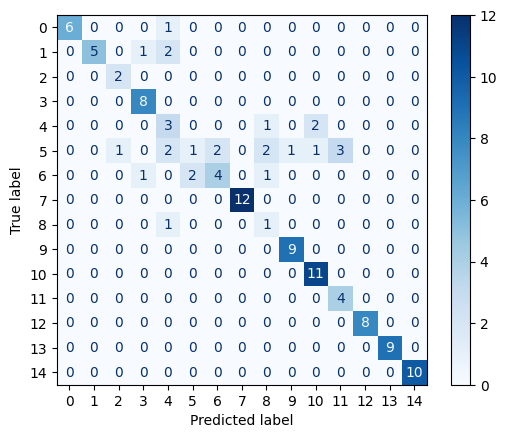

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(Y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")

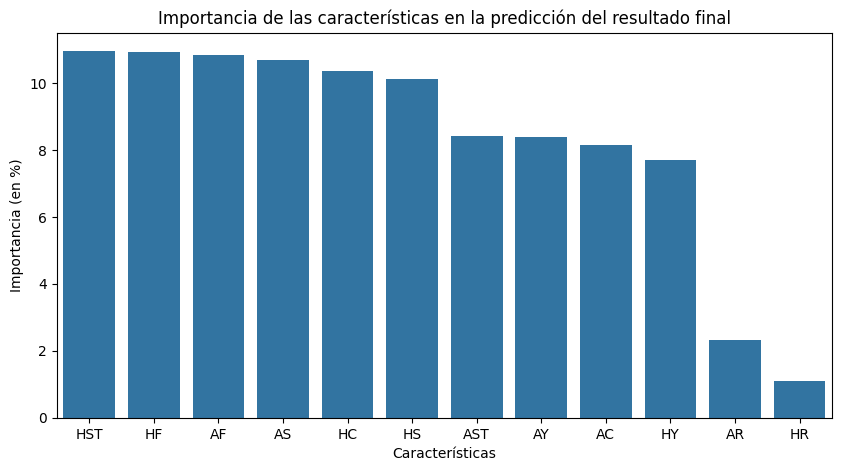

In [43]:
feature_importance = model.feature_importances_
features_names = X.columns

# Verificamos que sea igual a 1
np.sum(feature_importance)

feature_importance_df = pd.DataFrame({"Feature": features_names, "Importance": feature_importance}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=feature_importance_df['Feature'], y=feature_importance_df['Importance']*100)
plt.title("Importancia de las características en la predicción del resultado final")
plt.xlabel('Características')
plt.ylabel('Importancia (en %)')
plt.show()

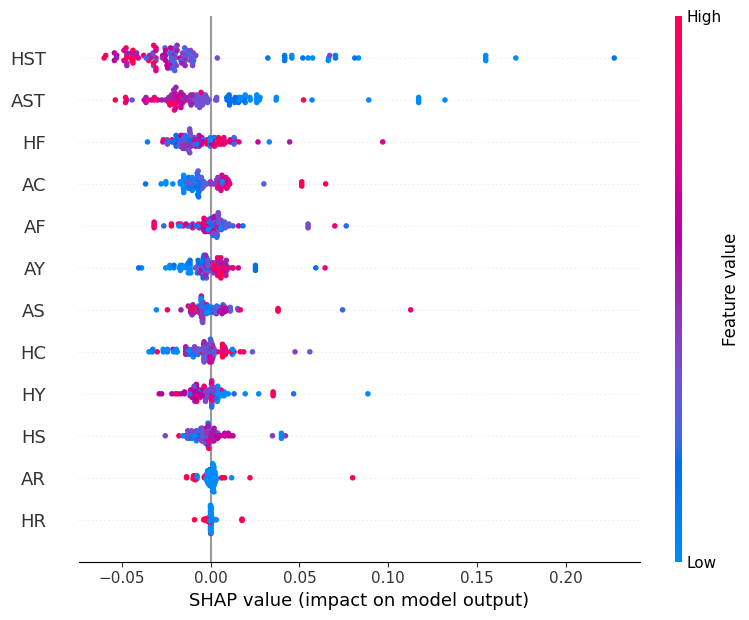

In [ ]:
treeExplainer = shap.TreeExplainer(model)
shap_values = treeExplainer.shap_values(X_test)

shap.summary_plot(shap_values[:, :, 0], X_test)

<h2> XGBOOST RANDOM CLASSIFIER </h2>

In [14]:
from sklearn.model_selection import RandomizedSearchCV

X_train_xgb, X_test_xgb, Y_train_xgb, Y_test_xgb = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

randomOverSampler = RandomOverSampler(random_state=42)

X_resampled_xgb, Y_resampled_xgb = randomOverSampler.fit_resample(X, Y)

Y_encoded_resampled_xgb = encoder.fit_transform(Y_resampled_xgb)

X_train_xgb, X_test_xgb, Y_train_xgb, Y_test_xgb = train_test_split(X_resampled_xgb, Y_encoded_resampled_xgb, test_size=0.2, random_state=42)


parameters = {
    "n_estimators": [100, 200, 250, 300, 350, 400],
    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.06, 0.07],
    "max_depth": [1,3,5,7,10]
}


modelXGM = RandomizedSearchCV(XGBClassifier(random_state = 42), parameters, scoring='accuracy', n_iter=15)

modelXGM.fit(X_train_xgb, Y_train_xgb)

print(f"Mejores parámetros: {modelXGM.best_params_}")
print(f"Mejor precision: {modelXGM.best_score_}")

c:\Users\jorge\Proyectos Python\NotMaster\FootballResults\.venv\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\jorge\Proyectos Python\NotMaster\FootballResults\.venv\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Mejores parámetros: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05}
Mejor precision: 0.80132692747655


In [15]:
modelXGM.score(X_test_xgb, Y_test_xgb)

0.8290598290598291

In [48]:
joblib.dump(modelXGM.best_estimator_, 'modelo_xgboost.pkl')

['modelo_xgboost.pkl']

In [49]:
modelXGM = joblib.load('modelo_xgboost.pkl')

y_pred_XGM = modelXGM.predict(X_test_xgb)
y_pred_labels_xgb = encoder.inverse_transform(y_pred_XGM)
print(y_pred_labels_xgb)

['2-1' '2-3' '3-1' '3-0' '3-2' '0-3' '2-3' '0-1' '2-0' '2-0' '3-2' '1-1'
 '4-1' '0-3' '2-3' '0-0' '1-2' '2-0' '4-1' '0-1' '2-0' '2-1' '0-1' '4-1'
 '3-1' '2-1' '2-0' '4-1' '2-3' '0-1' '3-0' '2-3' '3-0' '0-1' '2-3' '0-3'
 '2-2' '2-0' '2-3' '3-2' '0-1' '1-2' '0-3' '3-1' '2-3' '2-0' '1-2' '3-1'
 '3-1' '3-1' '0-0' '0-1' '2-1' '4-1' '2-2' '0-0' '3-2' '2-2' '2-3' '2-3'
 '1-0' '0-0' '2-3' '1-2' '3-1' '0-3' '0-1' '2-2' '2-2' '2-1' '1-0' '1-0'
 '2-2' '0-3' '2-0' '2-2' '0-0' '1-2' '2-0' '3-2' '2-2' '1-2' '1-2' '2-0'
 '2-3' '2-0' '3-0' '2-3' '0-2' '0-2' '0-3' '3-2' '1-1' '3-2' '2-2' '4-1'
 '0-3' '2-2' '1-2' '3-2' '2-0' '4-1' '0-1' '2-3' '3-1' '4-1' '0-0' '3-2'
 '2-2' '1-0' '1-0' '3-0' '0-3' '4-1' '1-2' '4-1' '2-0']


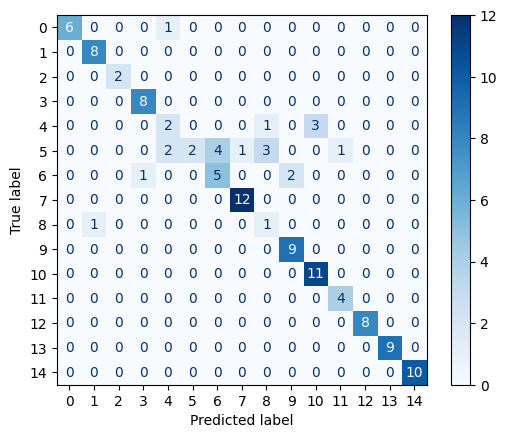

In [50]:
cm = confusion_matrix(Y_test, y_pred_XGM)

ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")

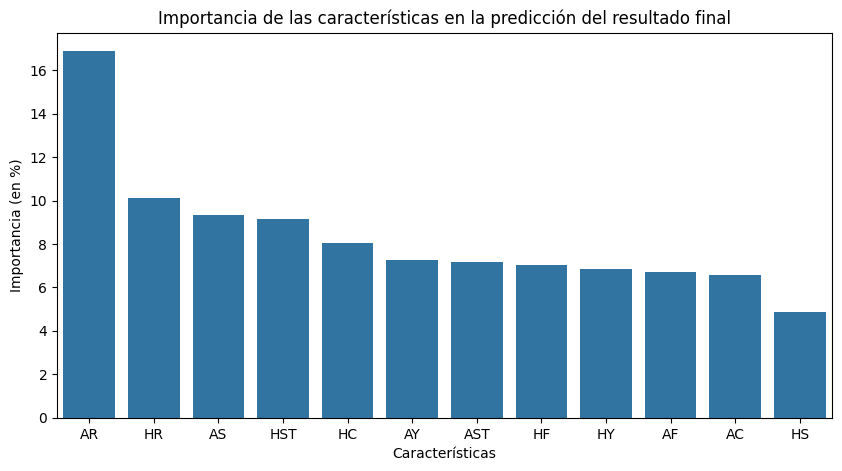

In [52]:
feature_importance_xgb = modelXGM.feature_importances_
features_names_xgb = X.columns

# Verificamos que sea igual a 1
np.sum(feature_importance_xgb)

feature_importance_xgb_df = pd.DataFrame({"Feature": features_names_xgb, "Importance": feature_importance_xgb}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=feature_importance_xgb_df['Feature'], y=feature_importance_xgb_df['Importance']*100)
plt.title("Importancia de las características en la predicción del resultado final")
plt.xlabel('Características')
plt.ylabel('Importancia (en %)')
plt.show()